In [ ]:
!pip install lightfm

In [ ]:
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import svds
from tqdm import tqdm

# Датасет

Будем работать с датасетом [MTS Library](https://www.kaggle.com/sharthz23/mts-library), содержащим данные об истории чтения книг пользователями МТС Библиотеки.

### Предобработка

In [ ]:
df = pd.read_csv('mts_lib.csv')
df.head()

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01
3,46791,83486,23,5.0,2018-01-01
4,79313,188770,88,5.0,2018-01-01


In [ ]:
# конвертируем в дату
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'], format="%Y-%m-%d")
# удаляем дубликаты, оставляя последний по времени
df = df.sort_values('start_date').drop_duplicates(subset=['user_id', 'item_id'], keep='last')

In [ ]:
def get_data_info(data, user_id='user_id', item_id='item_id'):
    print(f'Размер датасета = {data.shape[0]}, \nколичество пользователей = {data[user_id].nunique()}, \nколичество объектов = {data[item_id].nunique()}')

In [ ]:
get_data_info(df)

Размер датасета = 1532998, 
количество пользователей = 151600, 
количество объектов = 59599


### Filter data

In [ ]:
df = df[df['progress'] > 30]

In [ ]:
def filter_data(df, user_count=5, item_count=5):
    item_counts = df.groupby('item_id')['user_id'].count()
    pop_items = item_counts[item_counts >= user_count]
    df_implicit = df[df['item_id'].isin(pop_items.index)]

    user_counts = df.groupby('user_id')['item_id'].count()
    pop_users = user_counts[user_counts >= item_count]
    df = df[df['user_id'].isin(pop_users.index)].copy()
    return df

In [ ]:
df = filter_data(df)
get_data_info(df)

Размер датасета = 654819, 
количество пользователей = 64955, 
количество объектов = 59485


In [ ]:
u_features = pd.read_csv('users.csv')
i_features = pd.read_csv('items.csv')
i_features.rename(columns={'id': 'item_id'}, inplace=True)

In [ ]:
u_features.head()

,user_id,age,sex
0,1,45_54,NaN
1,2,18_24,0.0
2,3,65_inf,0.0
3,4,18_24,0.0
4,5,35_44,0.0


In [ ]:
i_features.head()

,item_id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894
2,95632,Испорченные дети,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1869
3,247906,Странный человек,"Пьесы и драматургия,Литература 19 века",Михаил Лермонтов,1831
4,294280,Господа ташкентцы,"Зарубежная классика,Классическая проза,Литерат...",Михаил Салтыков-Щедрин,1873


In [ ]:
i_features = i_features[i_features['item_id'].isin(df['item_id'])].copy()
u_features = u_features[u_features['user_id'].isin(df['user_id'])].copy()

In [ ]:
user_idx = df.user_id.astype('category').cat.codes
item_idx = df.item_id.astype('category').cat.codes
user2id = dict(zip(df.user_id, user_idx))
item2id = dict(zip(df.item_id, item_idx))

In [ ]:
df.user_id = df.user_id.map(user2id)
df.item_id = df.item_id.map(item2id)
i_features.item_id = i_features.item_id.map(item2id)
u_features.user_id = u_features.user_id.map(user2id)

### Train-test-split

In [ ]:
def train_test_split(X, user_col, time_col):
  full_history = X.sort_values([user_col, time_col]).groupby(user_col)
  test = full_history.tail(1)
  train = full_history.head(-1)
  return train, test

In [ ]:
train, test = train_test_split(df, 'user_id', 'start_date')

In [ ]:
test.head()

,user_id,item_id,progress,rating,start_date
1366165,0,35935,42,NaN,2019-10-14 00:00:00
874014,1,5890,100,NaN,2019-02-22 00:00:00
1514829,2,23269,88,NaN,2019-12-23 00:00:00
1276428,3,3854,40,NaN,2019-08-31 00:00:00
990325,4,14327,34,NaN,2019-04-18 00:00:00


# LightFM

[Статья](https://ceur-ws.org/Vol-1448/paper4.pdf?ref=https://githubhelp.com)

Гитхаб https://github.com/lyst/lightfm

LightFM объединяет коллабративную фильтрацию с контентными подходами.
Эмбеддинги пользователей и эмбеддинги объектов можно обучать как с использованием их признаков, так и без.

Если признаки используются, то эмбеддинги пользователей и объектов представляют собой сумму векторов их признаков (включая id как признак).

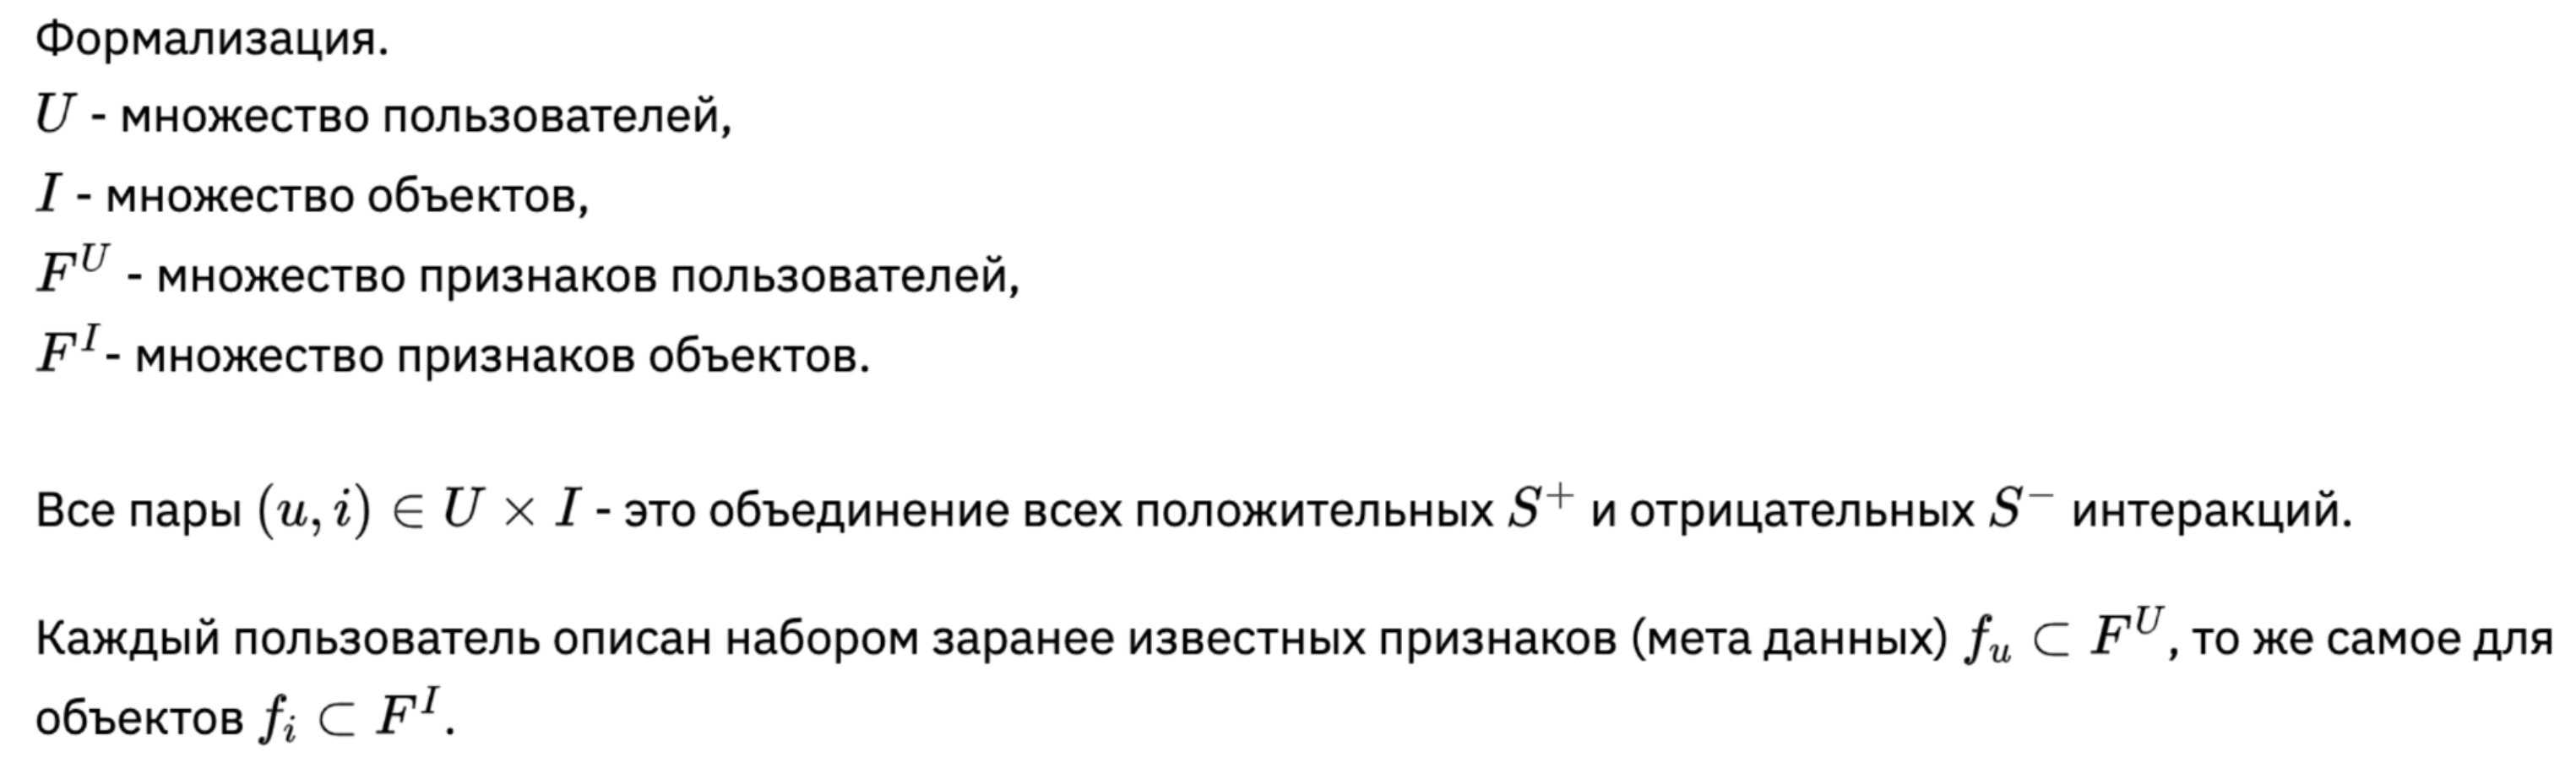

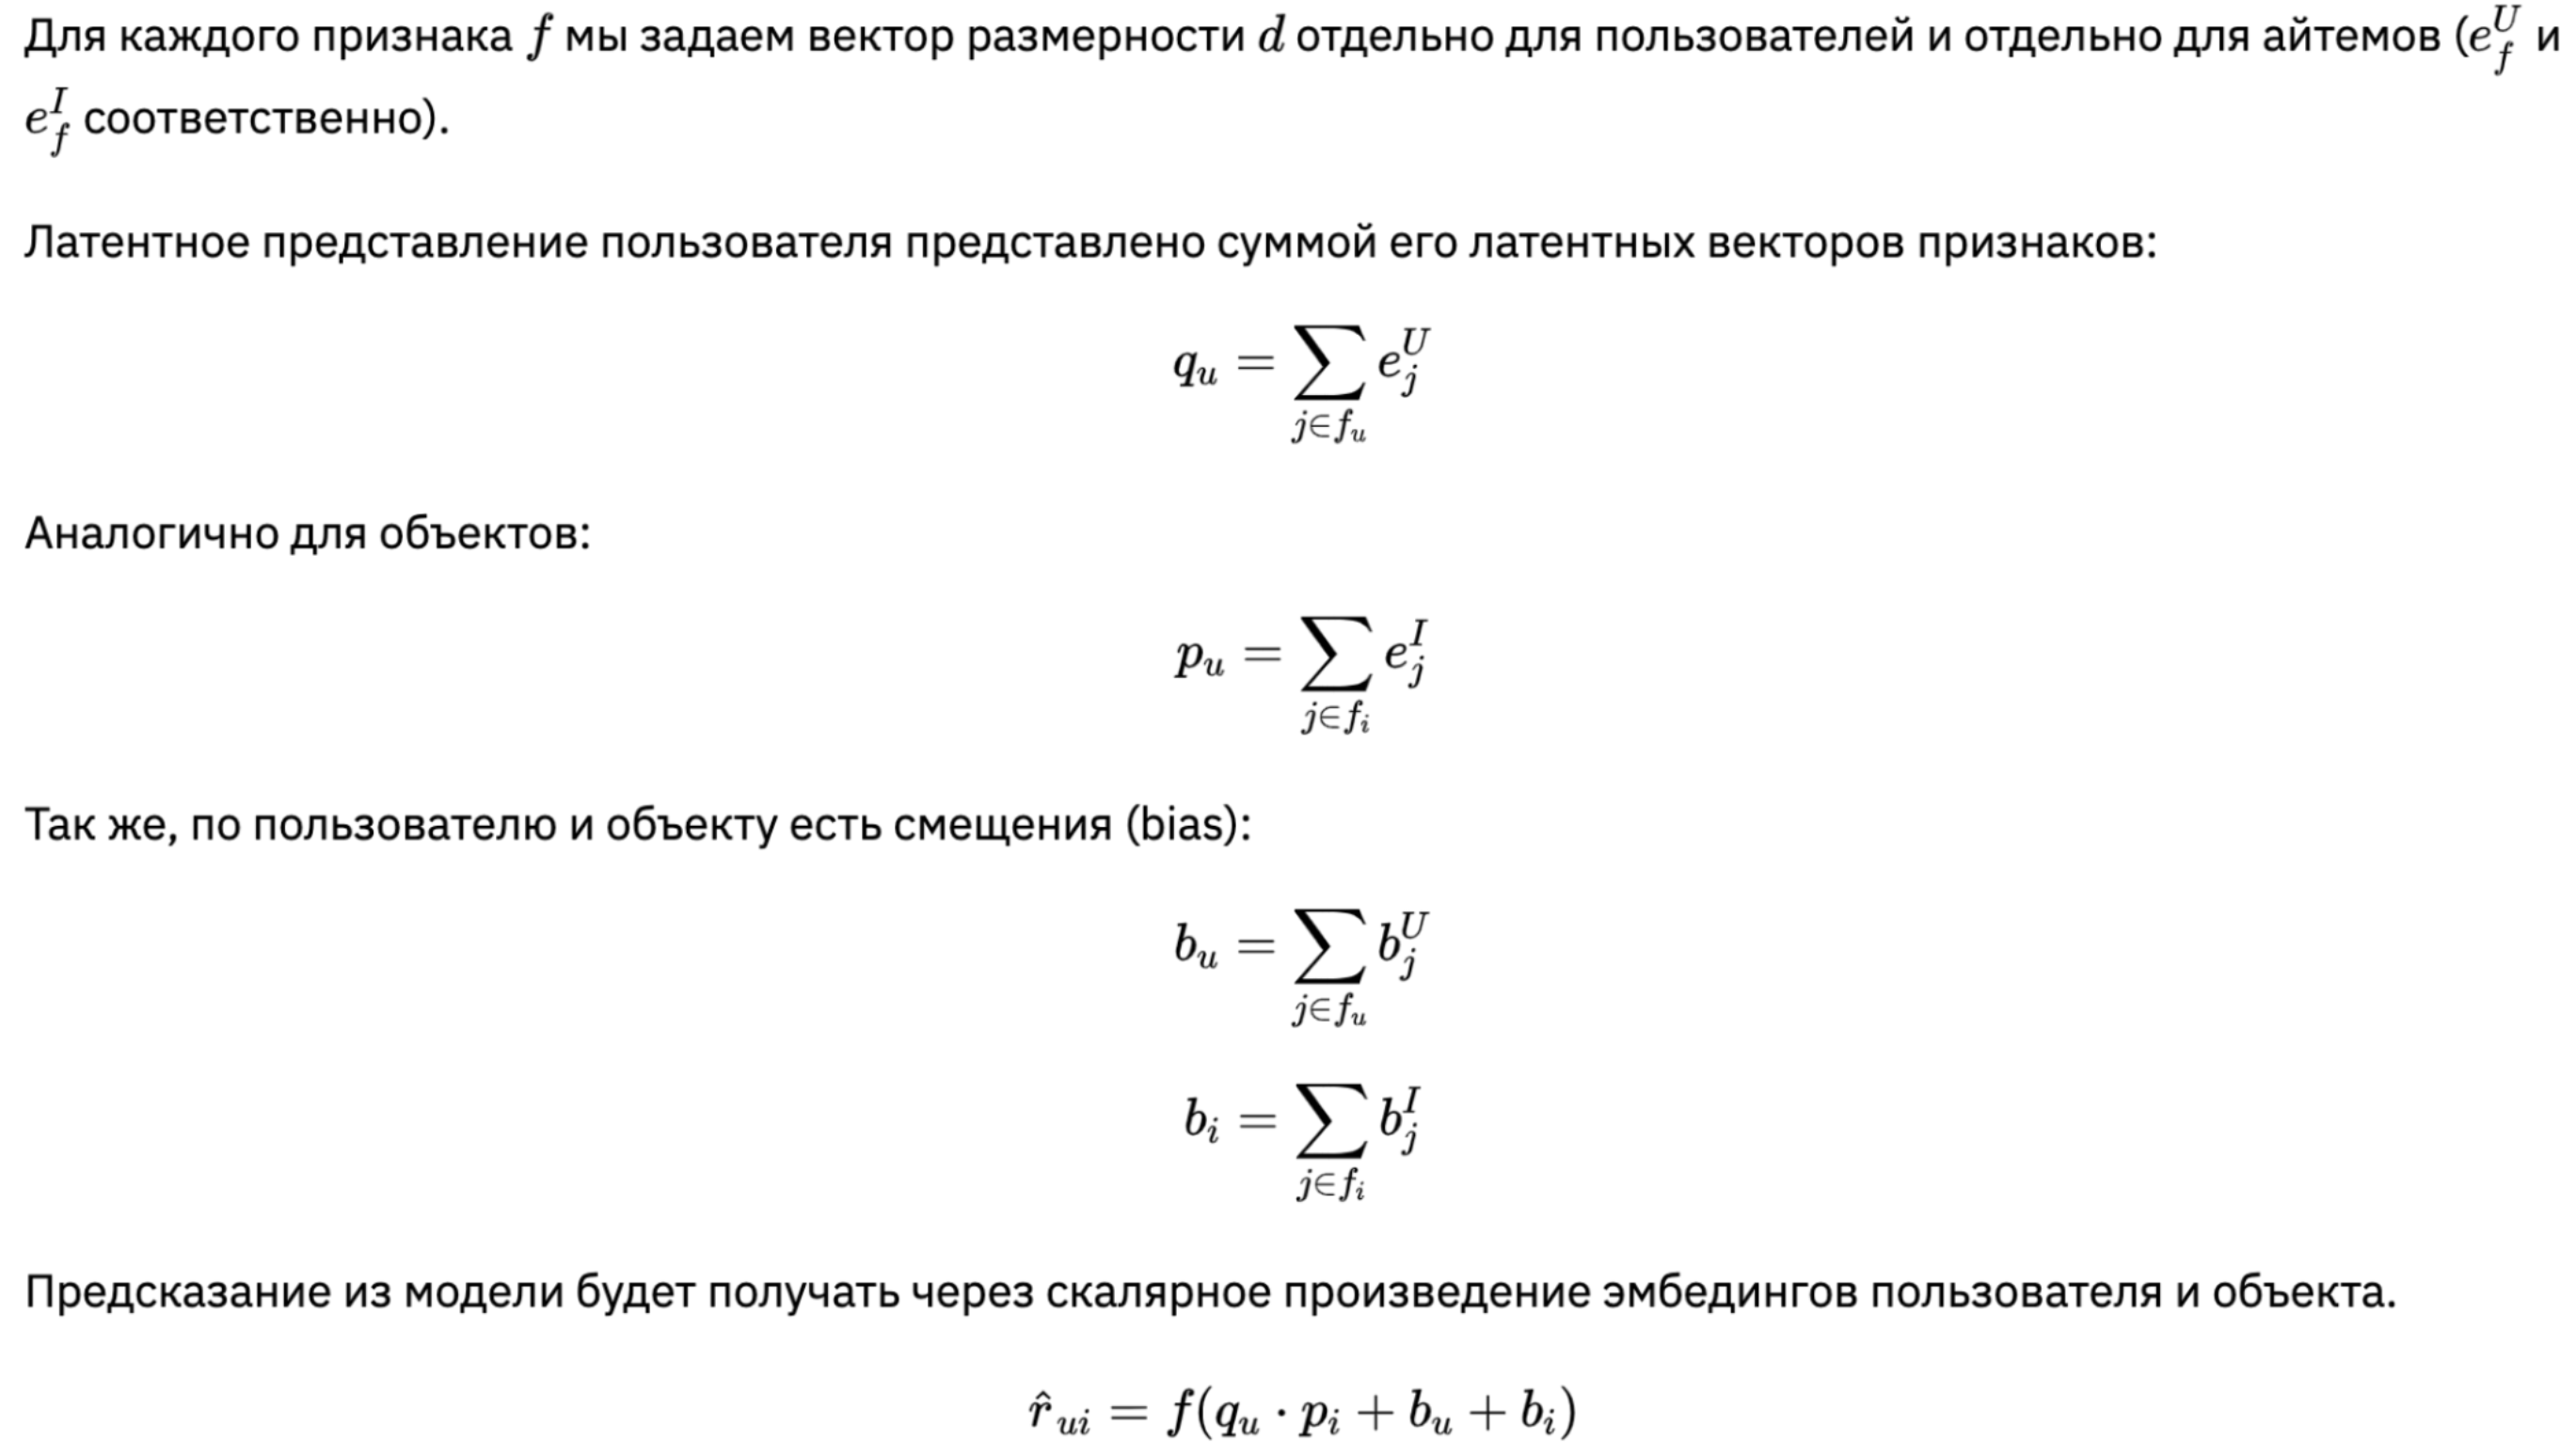

## Преобразование данных в формат датасета LightFM

В LightFM есть класс Dataset, который преобразует данные в нужный формат.

Подготовим признаки в виде series "id пользователя/объекта - list категориальных признаков, которые ему соответствуют".

### user features

In [ ]:
u_features.set_index('user_id', inplace=True)
u_features_list = u_features.apply(
    lambda feature_values: [f'{feature}_{feature_values[feature]}' for feature in feature_values.index if not pd.isna(feature_values[feature])],
    axis=1
    )
u_features_list = u_features_list.rename('features')

In [ ]:
u_features_list

user_id
1                  [age_45_54]
2        [age_65_inf, sex_0.0]
3         [age_55_64, sex_0.0]
4         [age_55_64, sex_1.0]
5         [age_25_34, sex_0.0]
                 ...          
64949     [age_18_24, sex_1.0]
64950     [age_18_24, sex_0.0]
64951     [age_25_34, sex_0.0]
64952              [age_25_34]
64953     [age_35_44, sex_0.0]
Name: features, Length: 58529, dtype: object

In [ ]:
user_tags = set(u_features_list.explode().dropna().values)
user_tags

{'age_18_24',
 'age_25_34',
 'age_35_44',
 'age_45_54',
 'age_55_64',
 'age_65_inf',
 'sex_0.0',
 'sex_1.0'}

### item features

Возьмем топ-50 жанров в качестве признаков книг.

In [ ]:
i_features_lfm = i_features.copy()
i_features_lfm.set_index('item_id', inplace=True)
i_features_lfm['reads'] = df.groupby('item_id')['user_id'].count()
i_features_lfm['genres'] = i_features_lfm['genres'].str.lower().str.split(',')
i_features_lfm['genres'] = i_features_lfm['genres'].apply(lambda x: x if isinstance(x, list) else [])

In [ ]:
i_features_lfm.head()

,title,genres,authors,year,reads
item_id,,,,,
23785,Ворон-челобитчик,"[зарубежные детские книги, сказки, зарубежная ...",Михаил Салтыков-Щедрин,1886,11
39068,Скрипка Ротшильда,"[классическая проза, литература 19 века, русск...",Антон Чехов,1894,87
17639,Испорченные дети,"[зарубежная классика, классическая проза, лите...",Михаил Салтыков-Щедрин,1869,5
45920,Странный человек,"[пьесы и драматургия, литература 19 века]",Михаил Лермонтов,1831,6
54429,Господа ташкентцы,"[зарубежная классика, классическая проза, лите...",Михаил Салтыков-Щедрин,1873,7


In [ ]:
genres_count = i_features_lfm[['genres', 'reads']].explode('genres').groupby('genres')['reads'].sum()

In [ ]:
genres_count.sort_values(ascending=False)

genres
любовное фэнтези               72008
попаданцы                      52832
современные любовные романы    49248
современные детективы          46660
героическое фэнтези            40794
                               ...  
литература 7 класс                 3
экономическая статистика           2
воздушный транспорт                2
научно-практические журналы        2
математика 3 класс                 1
Name: reads, Length: 640, dtype: int64

In [ ]:
item_tags = genres_count.sort_values(ascending=False)[:50].index
item_tags[:10]

Index(['любовное фэнтези', 'попаданцы', 'современные любовные романы',
       'современные детективы', 'героическое фэнтези',
       'современная русская литература', 'боевая фантастика',
       'зарубежные любовные романы', 'боевое фэнтези', 'эротические романы'],
      dtype='object', name='genres')

In [ ]:
def filter_genres(genres_list, valid_genres=None):
    if not genres_list:
        return []
    return [genre for genre in genres_list if genre in valid_genres]

In [ ]:
i_features_lfm['features'] = i_features_lfm['genres'].apply(filter_genres, valid_genres=set(item_tags))

In [ ]:
i_features_list = i_features_lfm['features']
i_features_list

item_id
23785    [зарубежная классика, литература 19 века, русс...
39068               [литература 19 века, русская классика]
17639    [зарубежная классика, литература 19 века, русс...
45920                                 [литература 19 века]
54429    [зарубежная классика, литература 19 века, русс...
                               ...                        
8438                                 [политология, газеты]
59454                                [политология, газеты]
23311                 [политология, общая история, газеты]
6060                                  [журнальные издания]
12073             [журнальные издания, научная фантастика]
Name: features, Length: 59485, dtype: object

### LightFM Dataset
Посмотрим на то, в каком формате принимает данные lightfm и как использовать Dataset для конвертации.

LightFM работает со sparse-матрицами, dataset конвертирует данные в sparse формат.
Матрица взаимодействий — это матрица размером количество пользователей $\times$ количество объектов.
Матрицы признаков выглядят интереснее.

In [ ]:
lfm_dataset = LFMDataset()

In [ ]:
lfm_dataset.fit_partial(users=df['user_id'].unique(), items=df['item_id'].unique())
lfm_dataset.fit_partial(user_features=user_tags, item_features=item_tags)

In [ ]:
user_mapping, item_mapping = lfm_dataset.mapping()[0], lfm_dataset.mapping()[2]

In [ ]:
inv_user_mapping = {value: key for key, value in user_mapping.items()}
inv_item_mapping = {value: key for key, value in item_mapping.items()}

#### transform features

In [ ]:
lfm_dataset.interactions_shape()

(64955, 59485)

In [ ]:
i_features_list.reset_index()

,item_id,features
0,23785,"[зарубежная классика, литература 19 века, русс..."
1,39068,"[литература 19 века, русская классика]"
2,17639,"[зарубежная классика, литература 19 века, русс..."
3,45920,[литература 19 века]
4,54429,"[зарубежная классика, литература 19 века, русс..."
...,...,...
59480,8438,"[политология, газеты]"
59481,59454,"[политология, газеты]"
59482,23311,"[политология, общая история, газеты]"
59483,6060,[журнальные издания]


In [ ]:
sparse_i_features = lfm_dataset.build_item_features([[row.item_id, row.features] for row in i_features_list.reset_index().itertuples()])
sparse_u_features = lfm_dataset.build_user_features([[row.user_id, row.features] for row in u_features_list.reset_index().itertuples()])

In [ ]:
sparse_i_features.shape

(59485, 59535)

In [ ]:
i_features_list[51]

['книги о приключениях', 'триллеры', 'историческая фантастика']

In [ ]:
sparse_i_features[51, :].nonzero(), sparse_i_features[51, :].data

((array([0], dtype=int32), array([51], dtype=int32)),
 array([1.], dtype=float32))

#### transform interactions

In [ ]:
(interactions, weights) = lfm_dataset.build_interactions([(row.user_id, row.item_id, row.progress) for row in train.itertuples()])

Посмотрим на содержание матриц interactions и weights: используя матрицу interactions можно легко перейти от рейтингов к бинарному фидбеку. Будем использовать weights.

In [ ]:
interactions.shape, interactions.data, weights.data

((64955, 59485),
 array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 array([65., 78., 77., ..., 85., 60., 33.], dtype=float32))

## Train model

In [ ]:
%%time
lightfm = LightFM(no_components=50, loss='warp')
lightfm.fit(interactions, user_features=sparse_u_features, item_features=sparse_i_features, epochs=40, num_threads=8)

CPU times: user 3min 39s, sys: 273 ms, total: 3min 39s
Wall time: 2min 9s


## Предсказание для одного пользователя

Посмотрим рекомендации для любителя иронических детективов

In [ ]:
train[train.user_id == 2535].merge(i_features)

,user_id,item_id,progress,rating,start_date,title,genres,authors,year
0,2535,12954,38,NaN,2018-04-11 00:00:00,Последний дебют,"Зарубежная классика,Литература 19 века,Русская...",Александр Куприн,1889
1,2535,49451,100,NaN,2018-09-17 00:00:00,Украшение китайской бабушки,Иронические детективы,Наталья Александрова,NaN
2,2535,19854,100,NaN,2018-09-17 00:00:00,Марафон с риском для жизни,Иронические детективы,Наталья Александрова,2015
3,2535,40600,100,NaN,2018-09-17 00:00:00,Русалку за хвост не удержать,Иронические детективы,Наталья Александрова,2014
4,2535,3465,100,NaN,2018-11-14 00:00:00,Кодекс надежды,Современные детективы,Наталья Александрова,2018
5,2535,34092,100,NaN,2018-11-14 00:00:00,Мальтийская головоломка,Иронические детективы,Наталья Александрова,2008
6,2535,45727,100,5.0,2019-01-14 00:00:00,Дело – труба!,Иронические детективы,Наталья Александрова,2018
7,2535,19978,100,NaN,2019-02-04 00:00:00,Китайская кукла,Современные детективы,Наталья Александрова,2014
8,2535,12730,100,NaN,2019-02-04 00:00:00,Приманка для Цербера,Иронические детективы,Наталья Александрова,2019
9,2535,44069,100,NaN,2019-02-04 00:00:00,Венец многобрачия,Иронические детективы,Наталья Александрова,2018


In [ ]:
pred = lightfm.predict(user_ids=user_mapping[2535], item_ids=sorted(item_mapping.values()), user_features=sparse_u_features, item_features=sparse_i_features)

In [ ]:
pred

array([-149.88979, -149.59744, -150.80392, ..., -151.24602, -152.2033 ,
       -152.87553], dtype=float32)

In [ ]:
k = 50
ids = np.argpartition(pred, - k)[- k:]
rel = pred[ids]
res = pd.DataFrame(zip(ids, rel), columns=['item_id', 'relevance'])
res['item_id'] = res['item_id'].map(inv_item_mapping)

In [ ]:
res.merge(i_features)

,item_id,relevance,title,genres,authors,year
0,7405,-145.004181,Клеопатра с парашютом,Иронические детективы,Дарья Донцова,2012
1,18373,-144.987350,Бабочка в гипсе,Иронические детективы,Дарья Донцова,2010
2,16515,-144.989456,В постели с Кинг-Конгом,Иронические детективы,Дарья Донцова,2011
3,54794,-144.985428,Три желания женщины-мечты,Иронические детективы,Дарья Донцова,2015
4,16147,-144.946884,Неопознанный ходячий объект,Иронические детективы,Татьяна Полякова,2001
5,16173,-144.929443,Авоська с Алмазным фондом,Иронические детективы,Дарья Донцова,2015
6,53519,-144.949951,Запасной выход из комы,Иронические детективы,Дарья Донцова,2018
7,2130,-144.964096,Гадюка в сиропе,Иронические детективы,Дарья Донцова,2001
8,29477,-144.969849,Коррида на раздевание,Иронические детективы,Дарья Донцова,2018
9,18728,-144.939377,Любовь-морковь и третий лишний,Иронические детективы,Дарья Донцова,2005
